In [39]:
import pandas as pd
import numpy as np

In [40]:
bv = pd.read_csv("../data/external/bill_version.csv", sep=";", encoding="latin1", parse_dates=True).rename(columns={"id": "version_id"})
bills =  pd.read_csv("../data/external/bill.csv", sep=";", encoding="latin1", parse_dates=True).rename(columns={"id": "bill_id"})

In [41]:
partisan_lean = pd.read_csv("../data/derived/partisan_lean.csv", sep=",", encoding="latin1", parse_dates=True)
derived_features = pd.read_csv("../data/derived/basic_version_features.csv", sep=",", encoding="latin1", parse_dates=True).rename(columns={'id': 'version_id'})

In [42]:
df = bv[['version_id', 'bill_id']].merge(bills[['bill_id', 'chamber_id', 'session_id', 'signed']], on = 'bill_id')

In [43]:
df = df.fillna(0)
df.loc[df.signed != 0, 'signed'] = 1


In [44]:
partisan_lean.head()
df2 = df.merge(partisan_lean[['abbr', 'session_id', 'chamber_id', 'partisan_lean']], on = ['session_id', 'chamber_id'])

In [45]:
df_ml = df2.merge(derived_features, on = 'version_id')
df_ml['session_chamber'] = df_ml['abbr'].map(str) + "-" + df_ml['chamber_id'].map(int).map(str)

In [46]:
df_ml.head()

,version_id,bill_id,chamber_id,session_id,signed,abbr,partisan_lean,text_length,session_chamber
0,2119301,1092981,1.0,562,0,TN,0.236118,43841,TN-1
1,2708948,1092981,1.0,562,0,TN,0.236118,53832,TN-1
2,2708949,1092981,1.0,562,0,TN,0.236118,60077,TN-1
3,2708950,1092981,1.0,562,0,TN,0.236118,7175,TN-1
4,2708951,1092981,1.0,562,0,TN,0.236118,961,TN-1


In [47]:
df_ml = df_ml[['signed', 'session_chamber', 'partisan_lean', 'text_length']]

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
df_ml_y = df_ml[['signed']].values

In [50]:
from sklearn.preprocessing import OneHotEncoder

In [51]:
df_ml.head()

,signed,session_chamber,partisan_lean,text_length
0,0,TN-1,0.236118,43841
1,0,TN-1,0.236118,53832
2,0,TN-1,0.236118,60077
3,0,TN-1,0.236118,7175
4,0,TN-1,0.236118,961


In [52]:
enc = OneHotEncoder()
enc.fit(df_ml.session_chamber.values.reshape(-1,1))
#df_ml.session_chamber.values.reshape(-1,1).shape

OneHotEncoder()

In [53]:
len(enc.categories_[0])

85

In [54]:
sparse_one_hot = enc.transform(df_ml.session_chamber.values.reshape(-1,1))

In [55]:
df_ml_x = np.concatenate((df_ml[['partisan_lean', 'text_length']].values, sparse_one_hot.toarray()), axis=1)

#### ML Work

In [56]:
(X_train, X_test, Y_train, Y_test) = train_test_split(df_ml_x, df_ml_y, test_size=0.2)

In [57]:
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

In [58]:
Y_train

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=object)

In [59]:
dtrain = xgb.DMatrix(X_train, label = Y_train)
dtest  = xgb.DMatrix(X_test,  label = Y_test)


In [60]:
param = {'max_depth': 20, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc'}

In [61]:
bst = xgb.train(param, dtrain, 10)

In [62]:
ypred = bst.predict(dtest)

In [63]:
ypred

array([0.09289462, 0.2273753 , 0.04912949, ..., 0.16125429, 0.20131342,
       0.18518847], dtype=float32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

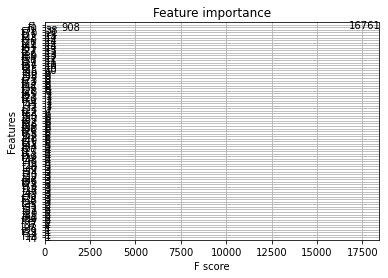

In [64]:
xgb.plot_importance(bst)

In [65]:
#roc_curve(Y_test, ypred)
Y_test.reshape(-1).shape

(99252,)

In [66]:
Y_test.astype(int)[:10,0]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1])

In [67]:
ypred.shape

(99252,)

In [68]:
fpr, tpr, thresholds = roc_curve(Y_test.astype(int).reshape(-1), ypred, pos_label=1)

In [69]:
from sklearn.metrics import roc_auc_score, classification_report

In [70]:
roc_auc_score(Y_test.astype(int).reshape(-1), ypred)

0.8159590253045413

In [71]:
ypred > 0.5

array([False, False, False, ..., False, False, False])

In [72]:
cr = classification_report(Y_test.astype(int).reshape(-1), ypred > 0.5)

In [73]:
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.89      0.86     72943
           1       0.60      0.48      0.53     26309

    accuracy                           0.78     99252
   macro avg       0.71      0.68      0.69     99252
weighted avg       0.77      0.78      0.77     99252

